In [12]:
from xlmrTrainer import Classifier
from transformers import XLMRobertaTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

In [8]:
test = pd.read_csv('../data/test.csv')
test_labels = pd.read_csv('../data/test_labels.csv', usecols=['toxic'])
test = pd.concat([test, test_labels], axis=1)
display(test)

,id,content,lang,toxic
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr,0
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru,0
2,2,"Quindi tu sei uno di quelli conservativi , ...",it,1
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr,0
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr,0
...,...,...,...,...
63807,63807,"No, non risponderò, come preannunciato. Prefer...",it,0
63808,63808,"Ciao, I tecnici della Wikimedia Foundation sta...",it,0
63809,63809,innnazitutto ti ringrazio per i ringraziamenti...,it,0
63810,63810,Kaç olumlu oy gerekiyor? Şu an 7 oldu. Hayır...,tr,0


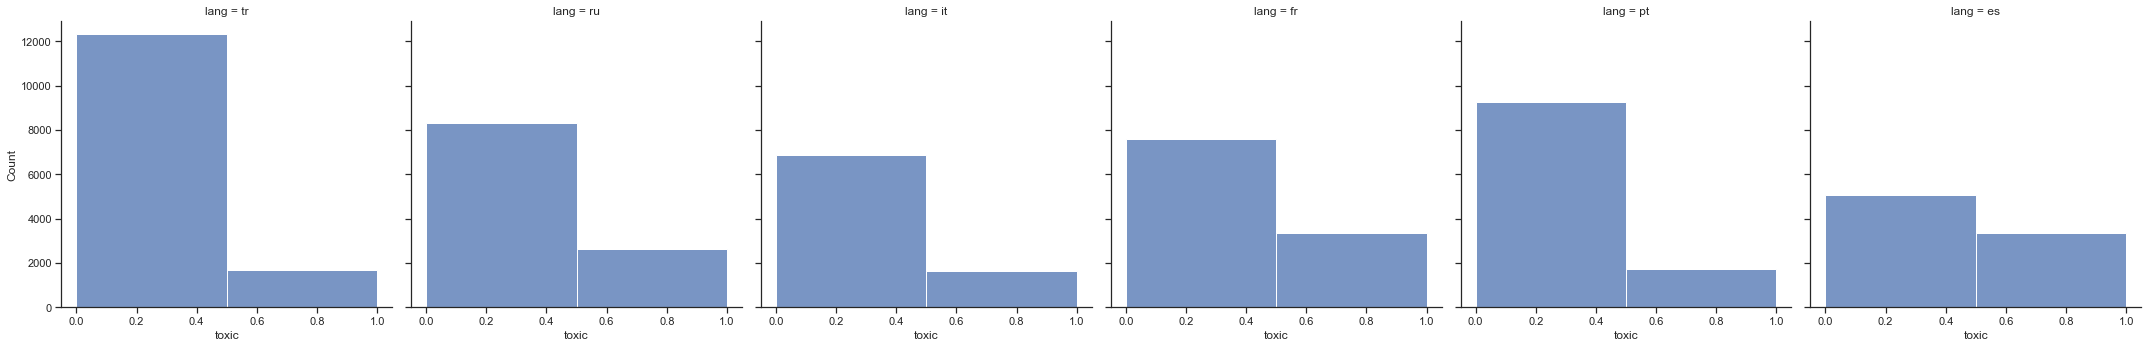

In [9]:
sns.set(style="ticks")
sns.displot(test, x="toxic", bins=2, stat='count', col='lang')
plt.show()

In [10]:
checkpoint = 'xlm-roberta-base'

In [11]:
xlmr = Classifier(checkpoint)
xlmr.load_state_dict(torch.load('../saved_models/xlm-roberta-base-87.51.pt'))

<All keys matched successfully>

In [14]:
comments = test.content.values
NUM_EXAMPLES = len(comments)

In [15]:
tokenizer = XLMRobertaTokenizer.from_pretrained(checkpoint)
input_ids = []
attention_mask = []
for i in tqdm(range(0, NUM_EXAMPLES, 1000)):
    encoded_content = tokenizer.batch_encode_plus(
        comments[i:i+1000], 
        add_special_tokens=True,
        max_length=200,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
        return_dict=False
    )
    input_ids.append(encoded_content['input_ids'])
    attention_mask.append(encoded_content['attention_mask'])

  0%|          | 0/64 [00:00<?, ?it/s]

In [16]:
input_ids = torch.cat(input_ids, dim=0)
attention_mask = torch.cat(attention_mask, dim=0)

In [17]:
predictions = []
batch_size = 64
for i in tqdm(range(0, NUM_EXAMPLES, batch_size)):
    size = input_ids[i:i+batch_size, :].shape[0]
    pred = xlmr.predict_prob(
        input_ids[i:i+batch_size, :].reshape(size, 200),
        attention_mask[i:i+batch_size, :].reshape(size, 200)
    )
    predictions.extend(pred)

  0%|          | 0/998 [00:00<?, ?it/s]

In [30]:
output = pd.DataFrame(torch.stack(predictions).cpu().numpy().round(2), columns=['non-toxic', 'toxic'])
display(output)
output.to_csv(
    '../results/xlmr-predictions.csv', 
    header=['non-toxic', 'toxic'] 
)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not numpy.ndarray

In [31]:
output = pd.read_csv('../results/xlmr-predictions.csv')

In [36]:
predictions = (output.toxic.values >= 0.4).astype(int)
test = pd.concat([test, pd.DataFrame(predictions, columns=['predictions'])], axis=1)
display(test)
true_labels = test.toxic.values

,id,content,lang,toxic,predictions
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr,0,0
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru,0,0
2,2,"Quindi tu sei uno di quelli conservativi , ...",it,1,0
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr,0,0
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr,0,0
...,...,...,...,...,...
63807,63807,"No, non risponderò, come preannunciato. Prefer...",it,0,0
63808,63808,"Ciao, I tecnici della Wikimedia Foundation sta...",it,0,0
63809,63809,innnazitutto ti ringrazio per i ringraziamenti...,it,0,1
63810,63810,Kaç olumlu oy gerekiyor? Şu an 7 oldu. Hayır...,tr,0,0


In [37]:
grouped_langs = test[['toxic', 'predictions', 'lang']].groupby(['lang'])
langs = test.lang.unique()

In [38]:
from sklearn.metrics import f1_score
lang_f1_score = {}
for lang in langs:
    labels = grouped_langs.get_group(lang).toxic.values
    preds = grouped_langs.get_group(lang).predictions.values
    lang_f1_score[lang] = [f1_score(labels, preds), len(labels)]
scores = pd.DataFrame(lang_f1_score, index=['f1 score', 'examples'] ).transpose()
scores.examples.astype(int)
display(scores)

,f1 score,examples
tr,0.590926,14000.0
ru,0.633649,10948.0
it,0.567059,8494.0
fr,0.655663,10920.0
pt,0.591308,11012.0
es,0.690686,8438.0


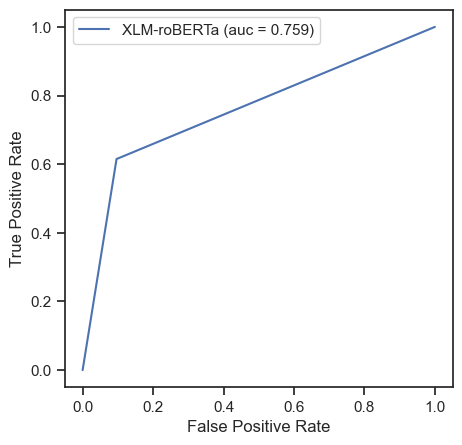

In [41]:
from sklearn.metrics import roc_curve, auc 
import matplotlib.pyplot as plt
xlmr_fpr, xlmr_tpr, threshold = roc_curve(true_labels, predictions)
auc_xlmr = auc(xlmr_fpr, xlmr_tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(xlmr_fpr, xlmr_tpr, label='XLM-roBERTa (auc = %0.3f)' % auc_xlmr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

